In [2]:
import os
import glob
import warnings

from itertools import product
# import tqdm
import gzip
import pickle
import json

import pandas as pd
import numpy as np
from scipy import stats
from scipy.signal import savgol_filter

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfd = tfp.distributions

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# load pTERT data

In [3]:
# content in last deepCSA run version
# ! ls /workspace/nobackup/bladder_ts/results/2025-03-28_deepCSA

run = '2025-03-28_deepCSA'
deepCSA_folder = f'/data/bbg/nobackup/bladder_ts/results/{run}'
clinical_fn = '/data/bbg/projects/bladder_ts/data/complete_cohort/samples_metadata/complete_cohort_bladder.discarded_histofindings_lowmuts.clinical_variables_extended.no_transposed.tsv'

In [7]:
def load_mutations():

    somatic_mutations_file = f'/data/bbg/nobackup/bladder_ts/results/{run}/somaticmutations/all_samples.somatic.mutations.tsv'
    somatic_mutations = pd.read_csv(somatic_mutations_file, sep='\t', low_memory=False)
    mutations = somatic_mutations[
        ~(somatic_mutations['FILTER'].str.contains("not_in_panel"))
        & (somatic_mutations['canonical_Consequence_broader'] == 'missense')
        & (somatic_mutations['TYPE'] == 'SNV')
    ]
    mutations = mutations[['CHROM', 'POS', 'REF', 'ALT', 'SYMBOL', 'SAMPLE_ID', 'ALT_DEPTH', 'ALT_DEPTH_AM', 'DEPTH', 'canonical_Consequence_broader']]
    return mutations

In [8]:
df_clinical = pd.read_csv(clinical_fn, sep='\t')
mutations = load_mutations()
ptert_mutations = mutations[mutations['SYMBOL'] == 'TERTpromoter']

In [9]:
ptert_mutations.head()

,CHROM,POS,REF,ALT,SYMBOL,SAMPLE_ID,ALT_DEPTH,ALT_DEPTH_AM,DEPTH,canonical_Consequence_broader
37714,chr5,1295018,C,T,TERTpromoter,P19_0015_BDO_01,5,7,638,missense
37715,chr5,1295034,C,A,TERTpromoter,P19_0048_BTR_01,4,13,2193,missense
37716,chr5,1295034,C,A,TERTpromoter,P19_0009_BTR_01,4,7,7953,missense
37717,chr5,1295034,C,A,TERTpromoter,P19_0007_BDO_01,1,2,1054,missense
37718,chr5,1295034,C,A,TERTpromoter,P19_0009_BDO_01,1,1,834,missense


In [10]:
# load depths at pTERT hotspots

ptert_panel = []
for fn in glob.glob(os.path.join(deepCSA_folder, 'annotatedepths', f'*.depths.annotated.tsv.gz')):
    sample_id = os.path.basename(fn).split('.')[0]
    if sample_id.startswith('P19'):
        df = pd.read_csv(fn, sep='\t')
        df.rename(columns={sample_id: 'DEPTH'}, inplace=True)
        df = df[(df['CHROM'] == 'chr5') & ((df['POS'] == 1295113) | (df['POS'] == 1295135))]
        df['SAMPLE_ID'] = sample_id
        ptert_panel.append(df)
ptert_panel = pd.concat(ptert_panel, axis=0)

In [11]:
ptert_seq = pd.merge(ptert_panel[['SAMPLE_ID', 'CHROM', 'POS', 'DEPTH']], 
    ptert_mutations[['SAMPLE_ID', 'CHROM', 'POS', 'ALT_DEPTH', 'REF', 'ALT']], 
    on=['SAMPLE_ID', 'CHROM', 'POS'], how='left').fillna(0)
ptert_seq = pd.merge(ptert_seq, df_clinical[['SAMPLE_ID', 'HISTORY_OF_SMOKING', 'AGE']], on=['SAMPLE_ID'], how='left')
ptert_seq['DONOR'] = ptert_seq['SAMPLE_ID'].apply(lambda r: '_'.join(r.split('_')[:2]))
ptert_seq.dropna(inplace=True)
ptert_seq = ptert_seq.groupby(by=['SAMPLE_ID', 'POS']).agg({**{'ALT_DEPTH': 'sum'}, **{c: 'first' for c in ptert_seq.columns if c \
    not in ['ALT_DEPTH', 'SAMPLE_ID', 'POS']}}).reset_index()
ptert_seq['SMOKING_COVARIATE'] = ptert_seq['HISTORY_OF_SMOKING'].apply(lambda r: int(r == 'yes'))
ptert_seq['HOTSPOT_COVARIATE'] = ptert_seq['POS'].apply(lambda r: int((r == 1295113) or (r == 1295135)))

In [12]:
# how many mutations in non-smokers

ptert_seq[(ptert_seq['HISTORY_OF_SMOKING'] == 'no') & (ptert_seq['ALT_DEPTH'] > 0)]

,SAMPLE_ID,POS,ALT_DEPTH,CHROM,DEPTH,REF,ALT,HISTORY_OF_SMOKING,AGE,DONOR,SMOKING_COVARIATE,HOTSPOT_COVARIATE
40,P19_0013_BDO_01,1295113,1.0,chr5,214,G,T,no,73,P19_0013,0,1


# simple binomial test

In [13]:
ptert_seq_hotspot1 = ptert_seq[ptert_seq['POS'] == 1295113]
ptert_seq_hotspot2 = ptert_seq[ptert_seq['POS'] == 1295135]

In [14]:
total_depth = ptert_seq_hotspot1[(ptert_seq_hotspot1['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot1['AGE'] > 55)]['DEPTH'].sum()
total_alt_depth = ptert_seq_hotspot1[(ptert_seq_hotspot1['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot1['AGE'] > 55)]['ALT_DEPTH'].sum()
mutrate_smoking_hotspot1 = total_alt_depth / total_depth

total_depth = ptert_seq_hotspot2[(ptert_seq_hotspot2['HISTORY_OF_SMOKING'] == 'yes')  & (ptert_seq_hotspot2['AGE'] > 55)]['DEPTH'].sum()
total_alt_depth = ptert_seq_hotspot2[(ptert_seq_hotspot2['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot2['AGE'] > 55)]['ALT_DEPTH'].sum()
mutrate_smoking_hotspot2 = total_alt_depth / total_depth

ptert_seq['MUTRATE'] = ptert_seq.apply(lambda r: mutrate_smoking_hotspot1 if r['POS'] == 1295113 else mutrate_smoking_hotspot2, axis=1)

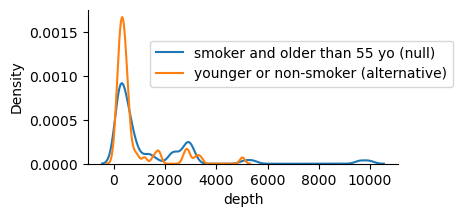

In [15]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(4,2))
depth_null = ptert_seq[(ptert_seq['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq['AGE'] > 55)]['DEPTH'].values
depth_alternative = ptert_seq[(ptert_seq['HISTORY_OF_SMOKING'] == 'no') | (ptert_seq_hotspot1['AGE'] <= 55)]['DEPTH'].values
sns.kdeplot(depth_null, bw=0.1, label='smoker and older than 55 yo (null)', ax=ax)
sns.kdeplot(depth_alternative, bw=0.1, label='younger or non-smoker (alternative)', ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('depth')
plt.legend(loc=(0.2, 0.5))
plt.show()

# calibrate mutrate to yield expected equal to observed in old-smokers

In [16]:
depth_null = ptert_seq[(ptert_seq['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq['AGE'] > 55)]['DEPTH'].astype(float).values
pvector_null = ptert_seq[(ptert_seq['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq['AGE'] > 55)]['MUTRATE'].astype(float).values
binomial_null = tfd.Binomial(total_count=depth_null, probs=pvector_null)

2025-04-07 14:00:21.282632: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 14:00:27.837829: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
observed = ptert_seq[(ptert_seq['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq['AGE'] > 55) & (ptert_seq['ALT_DEPTH'] > 0)].shape[0]
ptert_unique_muts = np.sum(binomial_null.sample(1000).numpy() >= 1, axis=1)
observed

32

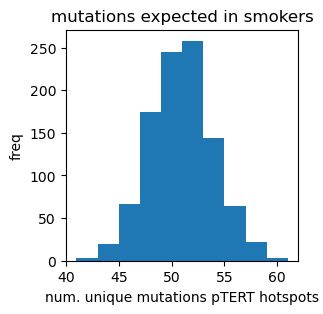

In [18]:
fig, ax = plt.subplots(figsize=(3,3))
plt.hist(ptert_unique_muts)
plt.title('mutations expected in smokers')
plt.ylabel('freq')
plt.xlabel('num. unique mutations pTERT hotspots')
plt.show()

# calibration of binomial test

In [19]:
def binomial_grid(factor):

    df = ptert_seq.copy()

    total_depth = ptert_seq_hotspot1[(ptert_seq_hotspot1['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot1['AGE'] > 55)]['DEPTH'].sum()
    total_alt_depth = ptert_seq_hotspot1[(ptert_seq_hotspot1['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot1['AGE'] > 55)]['ALT_DEPTH'].sum()
    mutrate_smoking_hotspot1 = (1 / factor) * (total_alt_depth / total_depth)

    total_depth = ptert_seq_hotspot2[(ptert_seq_hotspot2['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot2['AGE'] > 55)]['DEPTH'].sum()
    total_alt_depth = ptert_seq_hotspot2[(ptert_seq_hotspot2['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot2['AGE'] > 55)]['ALT_DEPTH'].sum()
    mutrate_smoking_hotspot2 = (1 / factor) * (total_alt_depth / total_depth)

    df['MUTRATE'] = ptert_seq.apply(lambda r: mutrate_smoking_hotspot1 if r['POS'] == 1295113 else mutrate_smoking_hotspot2, axis=1)

    depth_null = df[(df['HISTORY_OF_SMOKING'] == 'yes') & (df['AGE'] > 55)]['DEPTH'].astype(float).values
    pvector = df[(df['HISTORY_OF_SMOKING'] == 'yes') & (df['AGE'] > 55)]['MUTRATE'].astype(float).values
    bin_null = tfd.Binomial(total_count=depth_null, probs=pvector)

    ptert_unique_muts = np.sum(bin_null.sample(10000).numpy() >= 1., axis=1)
    obs = np.sum(df[(df['HISTORY_OF_SMOKING'] == 'yes') & (df['AGE'] > 55)]['ALT_DEPTH'].values >= 1.)
    return np.mean(ptert_unique_muts)

In [20]:
# calibrate

for f in np.linspace(1, 5, num=100):
    m = binomial_grid(f)
    if m > observed:
        continue
    else:
        break
mutrate_correction_factor = f
mutrate_correction_factor

3.505050505050505

# simple binomial test recalibrated

In [21]:
ptert_seq_hotspot1 = ptert_seq[ptert_seq['POS'] == 1295113]
ptert_seq_hotspot2 = ptert_seq[ptert_seq['POS'] == 1295135]

In [22]:
total_depth = ptert_seq_hotspot1[(ptert_seq_hotspot1['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot1['AGE'] > 55)]['DEPTH'].sum()
total_alt_depth = ptert_seq_hotspot1[(ptert_seq_hotspot1['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot1['AGE'] > 55)]['ALT_DEPTH'].sum()
mutrate_smoking_hotspot1 = (1 / mutrate_correction_factor) * (total_alt_depth / total_depth)

total_depth = ptert_seq_hotspot2[(ptert_seq_hotspot2['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot2['AGE'] > 55)]['DEPTH'].sum()
total_alt_depth = ptert_seq_hotspot2[(ptert_seq_hotspot2['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot2['AGE'] > 55)]['ALT_DEPTH'].sum()
mutrate_smoking_hotspot2 = (1 / mutrate_correction_factor) * (total_alt_depth / total_depth)

ptert_seq['MUTRATE'] = ptert_seq.apply(lambda r: mutrate_smoking_hotspot1 if r['POS'] == 1295113 else mutrate_smoking_hotspot2, axis=1)

In [23]:
depth_alternative = ptert_seq[(ptert_seq['HISTORY_OF_SMOKING'] == 'no') | (ptert_seq['AGE'] <= 55)]['DEPTH'].astype(float).values
pvector_alternative = ptert_seq[(ptert_seq['HISTORY_OF_SMOKING'] == 'no') | (ptert_seq['AGE'] <= 55)]['MUTRATE'].astype(float).values
binomial_alternative = tfd.Binomial(total_count=depth_alternative, probs=pvector_alternative)

In [24]:
observed = ptert_seq[((ptert_seq['HISTORY_OF_SMOKING'] == 'no') | (ptert_seq['AGE'] <= 55)) & (ptert_seq['ALT_DEPTH'] > 0)].shape[0]
ptert_unique_muts = np.sum(binomial_alternative.sample(10000).numpy() >= 1, axis=1)
observed

1

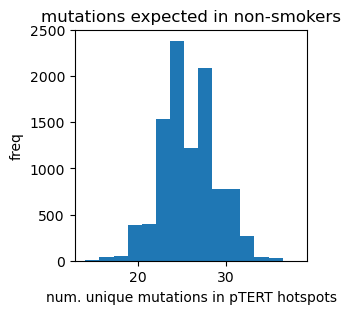

In [25]:
fig, ax = plt.subplots(figsize=(3,3))
plt.hist(ptert_unique_muts, bins=15)
plt.title('mutations expected in non-smokers')
plt.ylabel('freq')
plt.xlabel('num. unique mutations in pTERT hotspots')
plt.show()

# streamline simple binomial test

In [26]:
def binomial_test_grid(factor):

    df = ptert_seq.copy()

    total_depth = ptert_seq_hotspot1[(ptert_seq_hotspot1['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot1['AGE'] > 55)]['DEPTH'].sum()
    total_alt_depth = ptert_seq_hotspot1[(ptert_seq_hotspot1['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot1['AGE'] > 55)]['ALT_DEPTH'].sum()
    mutrate_smoking_hotspot1 = (1 / mutrate_correction_factor) * (1 / factor) * (total_alt_depth / total_depth)

    total_depth = ptert_seq_hotspot2[(ptert_seq_hotspot2['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot2['AGE'] > 55)]['DEPTH'].sum()
    total_alt_depth = ptert_seq_hotspot2[(ptert_seq_hotspot2['HISTORY_OF_SMOKING'] == 'yes') & (ptert_seq_hotspot2['AGE'] > 55)]['ALT_DEPTH'].sum()
    mutrate_smoking_hotspot2 = (1 / mutrate_correction_factor) * (1 / factor) * (total_alt_depth / total_depth)

    df['MUTRATE'] = df.apply(lambda r: mutrate_smoking_hotspot1 if r['POS'] == 1295113 else mutrate_smoking_hotspot2, axis=1)

    depth_alternative = df[(df['HISTORY_OF_SMOKING'] == 'no') | (df['AGE'] <= 55)]['DEPTH'].astype(float).values
    pvector_alternative = df[(df['HISTORY_OF_SMOKING'] == 'no') | (df['AGE'] <= 55)]['MUTRATE'].astype(float).values
    bin_alt = tfd.Binomial(total_count=depth_alternative, probs=pvector_alternative)

    ptert_unique_muts = np.sum(bin_alt.sample(1e5).numpy() >= 1., axis=1)
    obs = np.sum(df[(df['HISTORY_OF_SMOKING'] == 'no') | (df['AGE'] <= 55)]['ALT_DEPTH'].values >= 1.)
    pval = (np.sum(ptert_unique_muts <= obs) + 1) / 1e5
    return ptert_unique_muts, obs, pval

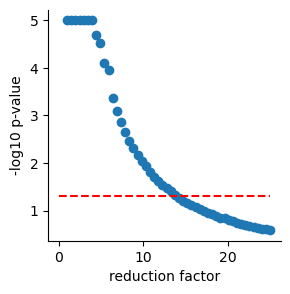

In [27]:
fig, ax = plt.subplots(figsize=(3,3))
x, y = [], []
for f in np.linspace(1, 25, num=50):
    x.append(f)
    ptert_unique_muts, obs, pval = binomial_test_grid(f)
    y.append(-np.log10(pval))
plt.scatter(x, y)
plt.hlines(-np.log10(0.05), 0, 25, linestyles='dashed', color='red')
plt.ylabel('-log10 p-value')
plt.xlabel('reduction factor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Panel Figure 4

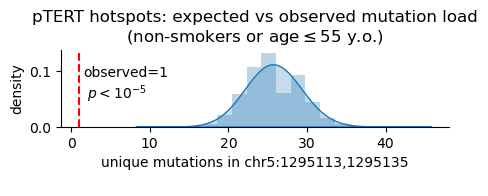

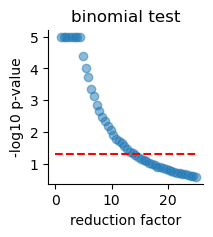

In [31]:
x, y = [], []
for i, f in enumerate(np.linspace(1, 25, num=50)):
    x.append(f)
    ptert_unique_muts, obs, pval = binomial_test_grid(f)
    y.append(-np.log10(pval))
    if i == 0:  # first iteration
        fig, ax = plt.subplots(figsize=(5,1))
        sns.kdeplot(ptert_unique_muts, shade=True, bw=0.5)
        plt.hist(ptert_unique_muts, density=True, bins=15, alpha=0.3)
        ax.set_title('pTERT hotspots: expected vs observed mutation load\n' \
            '(non-smokers or age$\leq$55 y.o.)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylabel('density')
        ax.set_xlabel('unique mutations in chr5:1295113,1295135\n')
        plt.axvline(obs, color='red', linestyle='--')
        ax.text(1.5, 0.05, 'observed=1\n $p<10^{-5}$')
        # plt.legend(loc=(0.05,0.5))
        # plt.savefig('../figures/binomialtest.smoking.age.svg', bbox_inches='tight')
        plt.savefig('plot/binomialtest.smoking.age.png', dpi=500, bbox_inches='tight')
        plt.show()

fig, ax = plt.subplots(figsize=(2,2))
plt.scatter(x, y, alpha=0.5)
plt.hlines(-np.log10(0.05), 0, 25, linestyles='dashed', color='red')
plt.ylabel('-log10 p-value')
plt.xlabel('reduction factor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('binomial test')
# plt.savefig('../figures/binomialtest.power.svg', bbox_inches='tight')
plt.savefig('plot/binomialtest.power.png', dpi=500, bbox_inches='tight')
plt.show()